In [680]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')


### 주식 종가 데이터 예측

데이터불러오기

In [862]:
df = pd.read_csv("./data/AAPL.csv") 
df1 = pd.read_csv("./data/MSFT.csv") 
df2 = pd.read_csv("./data/SPY.csv") 

print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-02-16,135.490005,136.009995,132.789993,133.190002,132.403061,80576300
1,2021-02-17,131.250000,132.220001,129.470001,130.839996,130.066956,97918500
2,2021-02-18,129.199997,130.000000,127.410004,129.710007,128.943634,96856700
3,2021-02-19,130.240005,130.710007,128.800003,129.869995,129.102661,87668800
4,2021-02-22,128.009995,129.720001,125.599998,126.000000,125.255539,103916400


- 주식시장은 주 5일 일하나보다 

In [682]:
df.head(10) 

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-02-16,135.490005,136.009995,132.789993,133.190002,132.403061,80576300
1,2021-02-17,131.250000,132.220001,129.470001,130.839996,130.066956,97918500
2,2021-02-18,129.199997,130.000000,127.410004,129.710007,128.943634,96856700
3,2021-02-19,130.240005,130.710007,128.800003,129.869995,129.102661,87668800
4,2021-02-22,128.009995,129.720001,125.599998,126.000000,125.255539,103916400
5,2021-02-23,123.760002,126.709999,118.389999,125.860001,125.116371,158273000
6,2021-02-24,124.940002,125.559998,122.230003,125.349998,124.609375,111039900
7,2021-02-25,124.680000,126.459999,120.540001,120.989998,120.275139,148199500
8,2021-02-26,122.589996,124.849998,121.199997,121.260002,120.543549,164560400
9,2021-03-01,123.750000,127.930000,122.790001,127.790001,127.034966,116307900


In [683]:
df["Date"]=pd.to_datetime(df["Date"])
df["year"]=df["Date"].dt.year
df["month"]=df["Date"].dt.month
df["day"]=df["Date"].dt.day

일단 휴장일이 없는 주의 데이터의 패턴을 모아서 보자

나중에 윈도우를 쓸 것을 생각해서 주 5일을 맞춰주도록 노력해보자.

In [684]:
df=df.loc[4:,].reset_index(drop=True)
df1=df1.loc[4:,].reset_index(drop=True)
df2=df2.loc[4:,].reset_index(drop=True)
df3=df3.loc[4:,].reset_index(drop=True)

In [685]:
print(df.shape, df1.shape, df2.shape,df3.shape)

(249, 10) (250, 7) (250, 7) (245, 7)


### 1. 애플의 종가 주식을 맞춰보자

In [686]:
ts2 = df['Close']  
print(type(ts2))
ts1.head()

<class 'pandas.core.series.Series'>


0    133.190002
1    130.839996
2    129.710007
3    129.869995
4    126.000000
Name: Close, dtype: float64

시계열 안정성(stationarity)을 정성적으로 체크한다.

In [687]:
ts2[ts2.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

.[pandas 결측값 보간하기](https://rfriend.tistory.com/264)
결측치가 없지만 보간하는 코드를 돌려보자

Series([], Name: Close, dtype: float64)


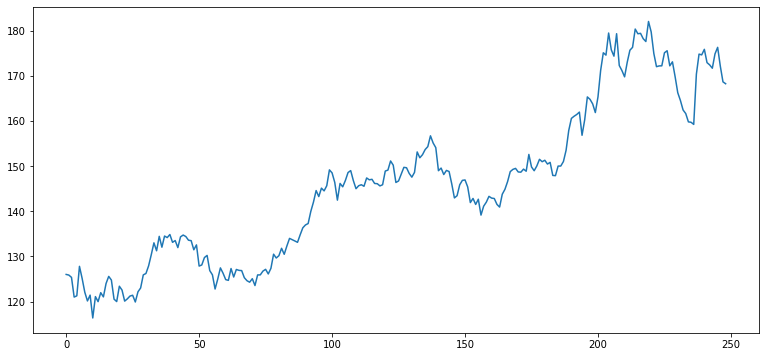

In [688]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts2=ts2.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts2[ts2.isna()])

# 다시 그래프를 확인해봅시다!
plt.plot(ts2)

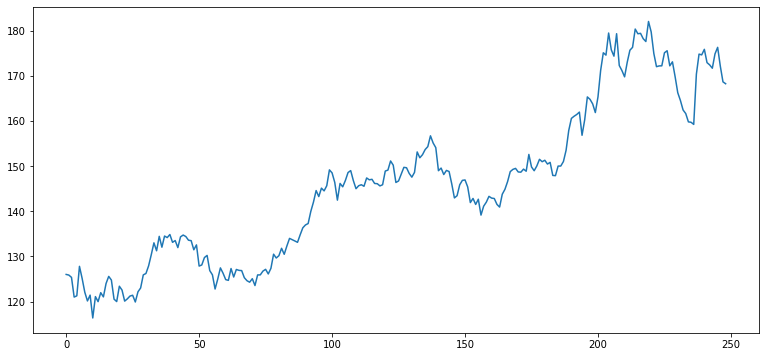

In [689]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts2)

__구간의 평균(rolling mean, 이동평균), 표준편차(rolling std, 이동표준편차)__ 를 추가한 그래프

In [690]:
def plot_rolling_statistics(timeseries, window=7):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


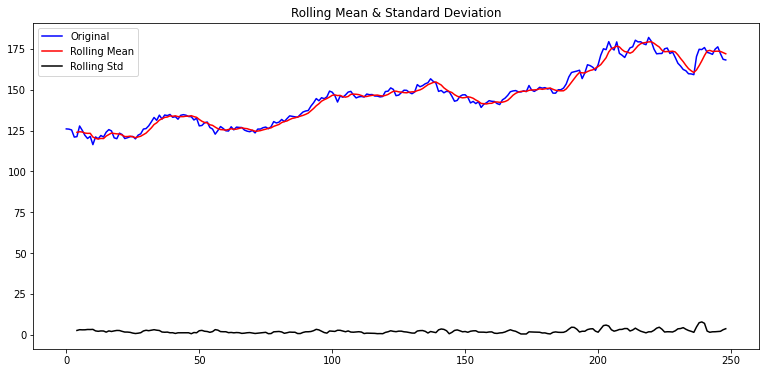

In [691]:
plot_rolling_statistics(ts2, window=5) # 주식시장이 일주일에 5일 

### 시계열 데이터 정량적으로 다뤄보기

#### Augmented Dickey-Fuller Test
> 1. "시계열데이터가 non- stationary하다"는 영가설(귀무가설, Null Hypothesis)을 세운다.
> 2. 만일 가설검정 과정을 통해 영가설이 기각된다면 대립가설을 채택한다.

- keyword: 귀무가설, 대립가설, p-value 

In [692]:
from statsmodels.tsa.stattools import adfuller


# ADF 테스트
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


In [693]:
augmented_dickey_fuller_test(ts2)

Results of Dickey-Fuller Test:
Test Statistic                  -0.944962
p-value                          0.772806
#Lags Used                       0.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


ADF 테스트 결과 p-value가 0.8로 1에 너무 가깝다. 즉 귀무가설을 기각못합니다.(하지만 시계열 데이터가 non-stationary는 증거는 아니다.)

### 11-6. 안정적인 시계열로 바꾸려면 어떻게 할까?

non-stationary한 시계열데이터를 stationary하게 바꾸는 방법   
1. 안정적(stationary) 특성을 갖도록 가공 - log 변환 등
2. 시계열분해(Time series decomposition) 


#### 1-1. log 변환


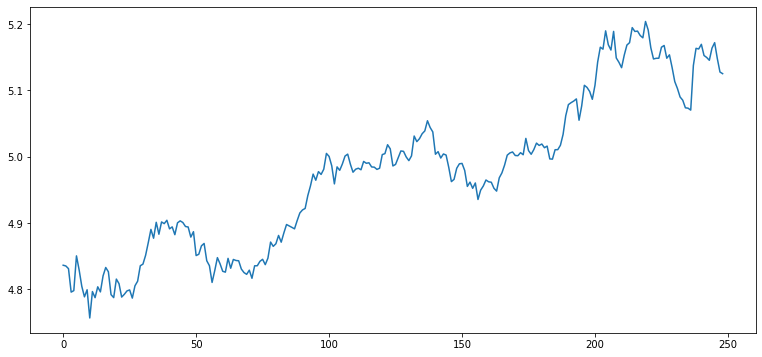

In [694]:
ts_log=np.log(ts2)
plt.plot(ts_log)

In [695]:
augmented_dickey_fuller_test(ts_log)  # log를 취해서 p-valu가0.83에서 0.82로 떨어졌다

Results of Dickey-Fuller Test:
Test Statistic                  -0.974629
p-value                          0.762405
#Lags Used                       0.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


#### 1-2. 이동평균(moving average) 제거하기
- 추세(trend)상쇄를 하기 위해서 moving average를 ts_log에서 빼서 시간추이에 따른 평균이 증가하는 것을 제거해준다.

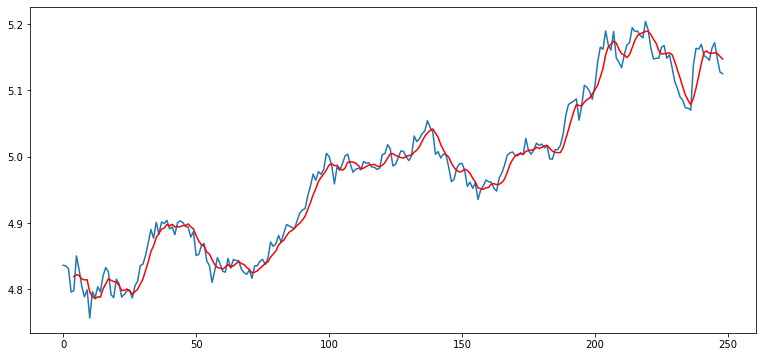

In [696]:
moving_avg = ts_log.rolling(window=5).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [697]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거

# window사이즈가 5개라서 앞의 4개 데이터의 결측치가 발생하기 때문에 결측치 삭제한다.
ts_log_moving_avg.dropna(inplace=True) 
ts_log_moving_avg.head(15)

4    -0.021304
5     0.028326
6     0.008390
7    -0.011051
8    -0.025563
9    -0.015145
10   -0.038972
11    0.007421
12    0.001649
13    0.014994
14    0.007983
15    0.019443
16    0.024839
17    0.010554
18   -0.021580
Name: Close, dtype: float64

로그변환을 하고, moving average를 뺀 이후의 변화를 보자

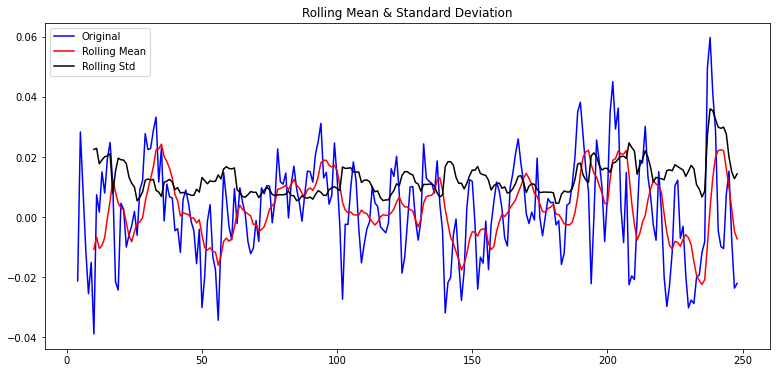

In [698]:
plot_rolling_statistics(ts_log_moving_avg)

In [699]:
augmented_dickey_fuller_test(ts_log_moving_avg) # p-value가 0.82에서 6*10^-12로 매우매우 감소했다.

Results of Dickey-Fuller Test:
Test Statistic                -6.136685e+00
p-value                        8.155006e-08
#Lags Used                     6.000000e+00
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


### 주의사항
-  __moving average의 window 사이즈를 어떻게 잡느냐에 따라서__ 시계열데이터에서 moving average를 뺀 이후에 trend를 제거되는지 안되는지가 달라진다. 즉 __시계열 데이터가 안정적이 되는지 안되는지가 달라진다.__

#### 1-3. 차분(differencing)- 계절성(Seasonality) 상쇄하기
- 계절적, 주기적 패턴을 계절성(seasonality)라고 하는데 이런  주기적 변화를 제거한다.


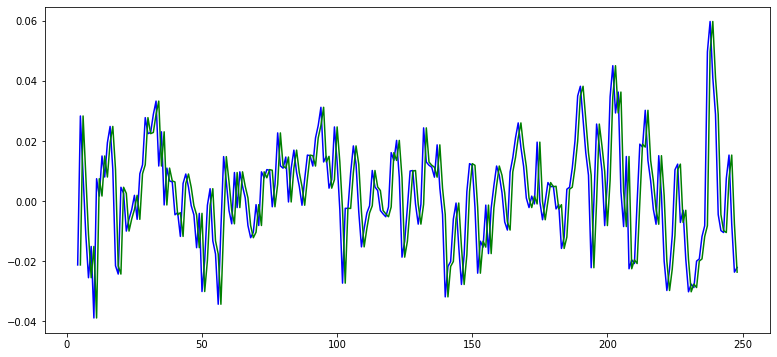

In [700]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift() # 한칸씩 shift

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

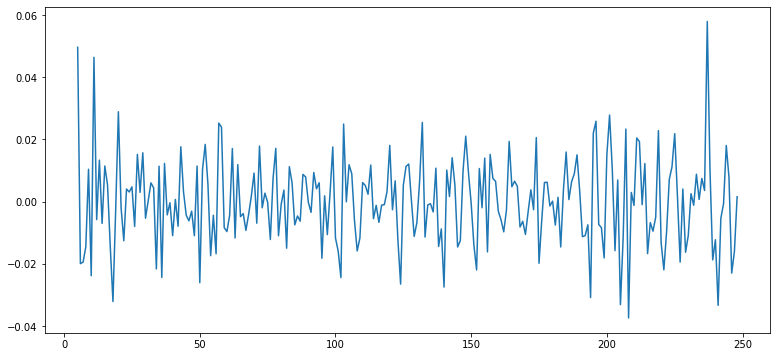

In [701]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

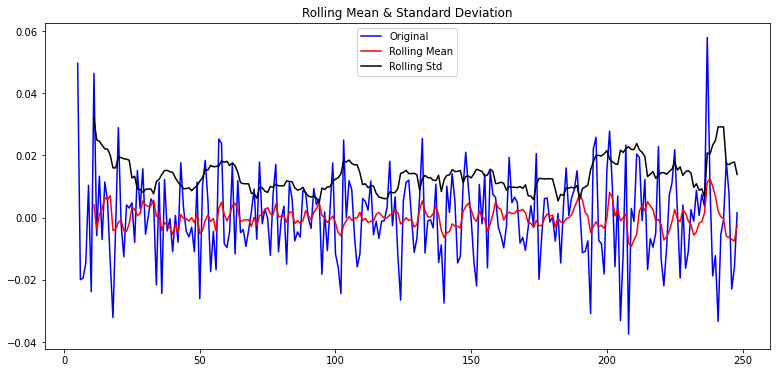

In [702]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [703]:
# log 변환, 이동평균 빼주고  p-value  2.359587e-11이다. 
augmented_dickey_fuller_test(ts_log_moving_avg_diff) 

Results of Dickey-Fuller Test:
Test Statistic                -7.602019e+00
p-value                        2.375492e-11
#Lags Used                     1.200000e+01
Number of Observations Used    2.310000e+02
Critical Value (1%)           -3.458980e+00
Critical Value (5%)           -2.874135e+00
Critical Value (10%)          -2.573482e+00
dtype: float64


## 2. 시계열 분해(time series decomposition)
- statsmodels 라이브러리 안의 seasonal_decompose 메서드를 통해서 시계열 안에 존재하는 tred, seasonality를 분리할수 있음.
- 앞에서는 이 과정을 손수 나눠서 빼보는 것이었음. 사실 이거 한번에 하면 됨

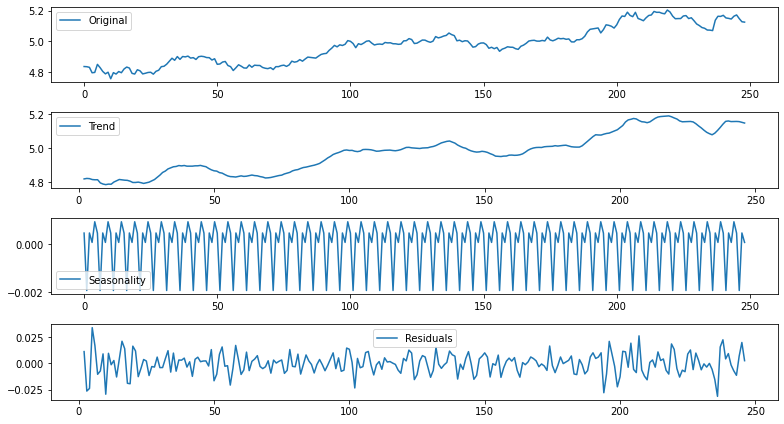

In [704]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='additive', period=5)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

original=trend+seasonal+residual

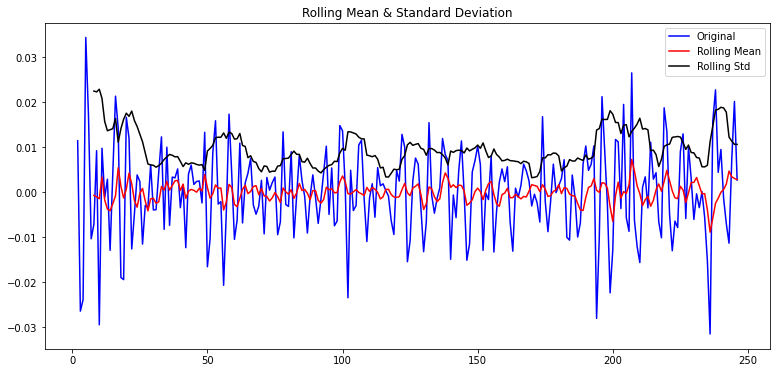

In [705]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [706]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -8.374115e+00
p-value                        2.614132e-13
#Lags Used                     1.200000e+01
Number of Observations Used    2.320000e+02
Critical Value (1%)           -3.458855e+00
Critical Value (5%)           -2.874080e+00
Critical Value (10%)          -2.573453e+00
dtype: float64


Decomposing을 통해서 얻어진 Residual은 낮은 p-value를 보여준다. 예측가능한 수준의 안정적인 시계열이 얻어젔다고 말할수 있다. 

## ARIMA(Autoregressive Integrated Moving Average) 개념
- 시계열 데이터=trend+seasonality+residual 이고, 잘 분리한 Residual은 예측력있는 안정적인 시계열 데이터가 된다.
- __ARIMA= AR(Autoregressive) + I(Integrated) + MA(Moving Average)__

- 시계열 데이터 $Y=\{Y_{t}:t \in T \}$의 $Y_{t}$를 예측하기 위한 모델
>- __AR__(자기회귀,AutoRegressive): 과거 값들에 대한 회귀로 미래 값을 예측하는 방법, 시계열에 Residual에 해당
>- __I__(차분누적, Integration): I는 $Y_{t}$ 이전 데이터와 $d$차 차분의 누적(integration) 합, 시계열의 Seasonality에 해당
>- __MA__(이동평균, Moving Average): MA는 $Y_{t}$가 이전 q개의 예측 오차값의 가중합으로 수렴한다고 보는 모델로 시계열의 trend에 해당.

만일 어제 비트코인 값이 떨어졌다면, 
- AR은 '오늘 코인값이 떡상해서, 코인값이 항상 일정한 균형 수준을 유지하겠지?'
- MA는 '오늘 코인값이 계속 떨어지겠지?'  
이렇게 생각하는 것이라고 보고 이 두 모델 사이를 적절하게 찾아가는게 ARIMA의 능력이다.

### ARIMA 모델의 모수 p,q,d
- ARIMA를 효과적으로 활용하기 위해 ARIMA 모수(parameter)를 잘 설정해주어야한다.
- p: 자기회귀모형(AR)의 시차/ d: 차분 누적(I) 횟수/ q: 이동평균모형(MA)의 시차
------------------
- 일반적으로 p+q<2, p* q=0 을 쓴다.
- p, q 둘 중 하나는 0이라는 뜻이다. 
--------------------
### ARIMA의 파라미터 p,q,d를 찾는 통계학적인 방법 
> #### ACF(Autocorrelation Function)   
> - lag에 따라 관측치들 사이의 correlation 측정    
>
> #### PACF(Partial Autocorrelation Function)
> - 두 시차의 관측치 사이의 관련성 측정(TODO)

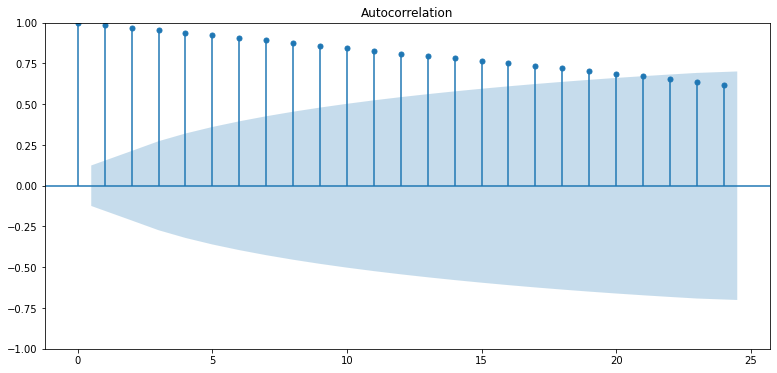

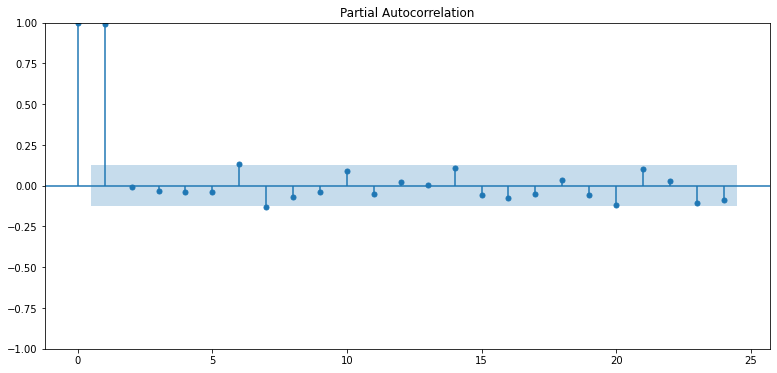

In [707]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

PACF를 통해 AR 모델의 시차 p를 1이 적합하다고 생각했다. p가 2이상인 구간에서는 PACF는 거의 0에 가까워지기 때문이다.

Results of Dickey-Fuller Test:
Test Statistic                -1.594739e+01
p-value                        7.422974e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.470000e+02
Critical Value (1%)           -3.457105e+00
Critical Value (5%)           -2.873314e+00
Critical Value (10%)          -2.573044e+00
dtype: float64


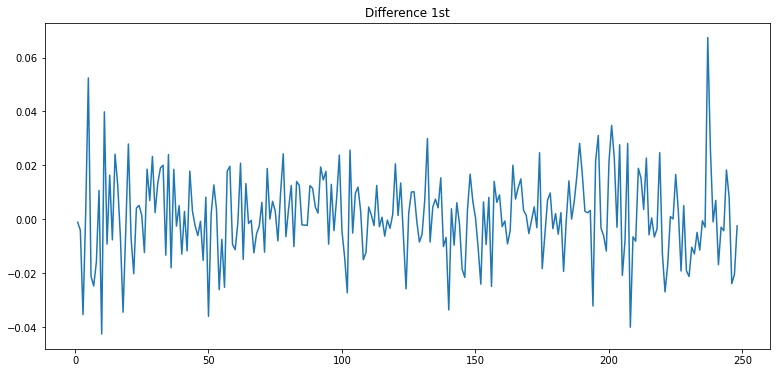

In [708]:
# 1차 차분 구하기 
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.850602e+00
p-value                        5.614657e-12
#Lags Used                     1.300000e+01
Number of Observations Used    2.320000e+02
Critical Value (1%)           -3.458855e+00
Critical Value (5%)           -2.874080e+00
Critical Value (10%)          -2.573453e+00
dtype: float64


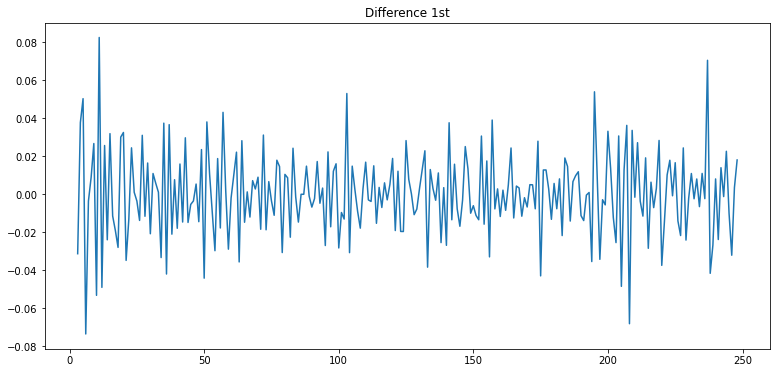

In [709]:
# 2차 차분 구하기 
diff_2 = diff_1.diff(periods=1).iloc[2:]
diff_2.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_2)

- 1차 차분이 적당할 것 같다.

학습데이터 분리

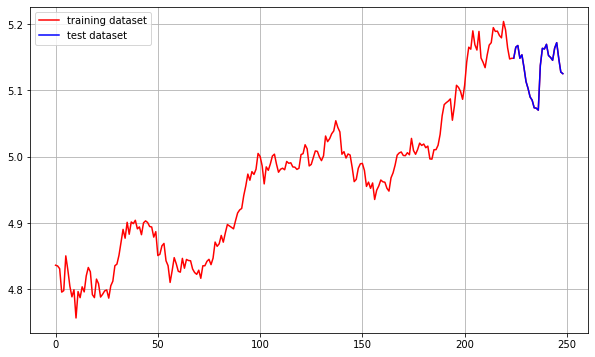

In [710]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  
# train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [711]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

0    4.836282
1    4.835170
Name: Close, dtype: float64
(224,)
(25,)


### ARIMA 모델 훈련과 추론

In [712]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 1, 0)) 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 617.398
Date:                Wed, 16 Feb 2022   AIC                          -1230.795
Time:                        17:14:27   BIC                          -1223.981
Sample:                             0   HQIC                         -1228.045
                                - 224                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0647      0.063     -1.020      0.308      -0.189       0.060
sigma2         0.0002   1.99e-05     11.583      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.04   Jarque-

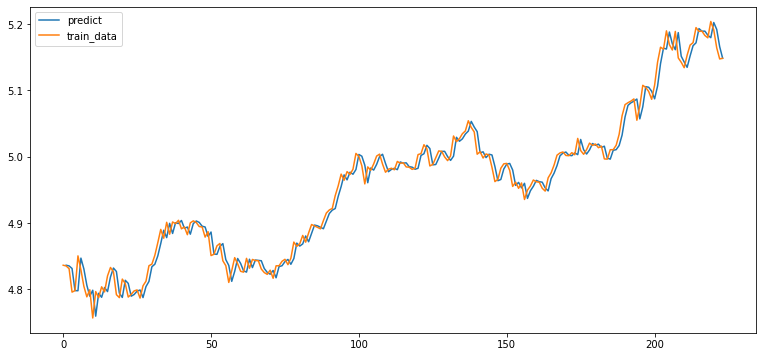

In [713]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

In [714]:
 # 앞의 PACF그래프를 통해서 p=1,q=0, 차수를 주면서 ADF테스트를 통해 d는 0이 맞음을 확인했다

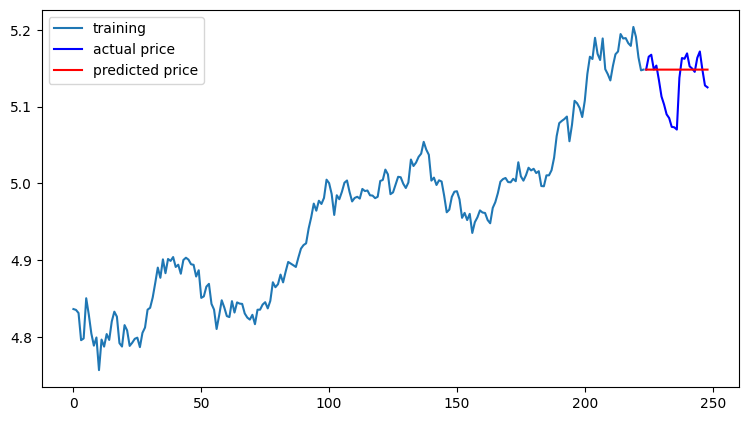

In [715]:
model = ARIMA(train_data, order=(1, 1, 0)) 
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [716]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  35.39524772045299
MAE:  4.304611806527118
RMSE:  5.949390533529716
MAPE: 2.61%


- __애플 주식을 시계열 ARIMA 모델로 예측한 결과 MAPE가 2.61%가 되었다.__

### 2. 마이크로 소프트의 종가 주식을 맞춰보자

In [717]:
ts2 = df1['Close']  
print(type(ts2))
ts1.head()

<class 'pandas.core.series.Series'>


0    133.190002
1    130.839996
2    129.710007
3    129.869995
4    126.000000
Name: Close, dtype: float64

시계열 안정성(stationarity)을 정성적으로 체크한다.

In [718]:
ts2[ts2.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

.[pandas 결측값 보간하기](https://rfriend.tistory.com/264)
결측치가 없지만 보간하는 코드를 돌려보자

Series([], Name: Close, dtype: float64)


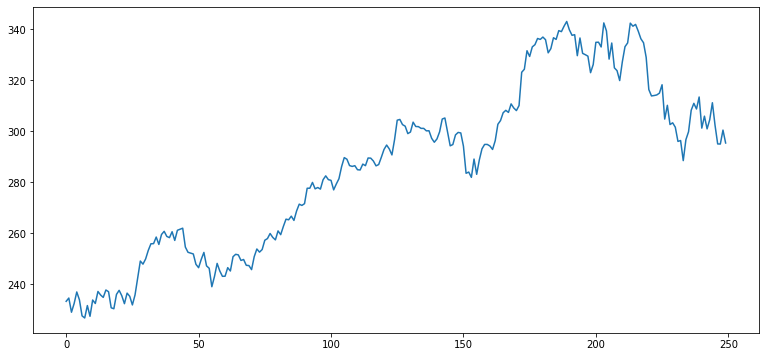

In [719]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts2=ts2.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts2[ts2.isna()])

# 다시 그래프를 확인해봅시다!
plt.plot(ts2)

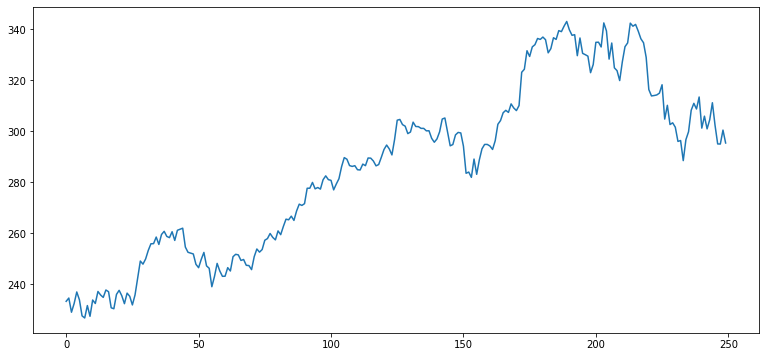

In [720]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts2)

__구간의 평균(rolling mean, 이동평균), 표준편차(rolling std, 이동표준편차)__ 를 추가한 그래프

In [721]:
def plot_rolling_statistics(timeseries, window=7):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


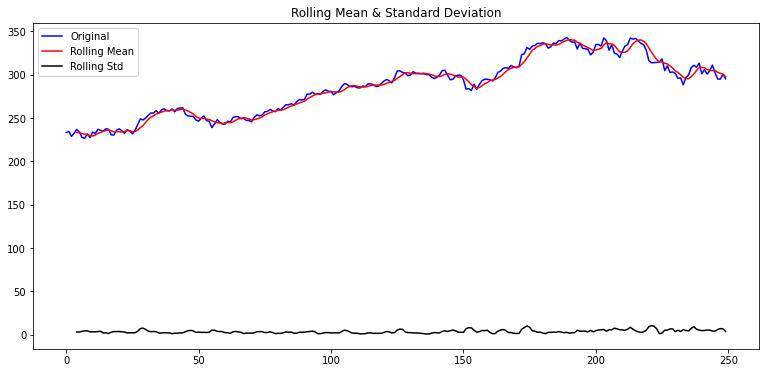

In [722]:
plot_rolling_statistics(ts2, window=5) # 주식시장이 일주일에 5일 

### 시계열 데이터 정량적으로 다뤄보기

#### Augmented Dickey-Fuller Test


In [723]:
from statsmodels.tsa.stattools import adfuller


# ADF 테스트
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


In [724]:
augmented_dickey_fuller_test(ts2)

Results of Dickey-Fuller Test:
Test Statistic                  -1.595662
p-value                          0.485772
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


ADF 테스트 결과 p-value가 0.4로 1에 가깝다. 즉 귀무가설을 기각못합니다.(하지만 시계열 데이터가 non-stationary는 증거는 아니다.)

### 11-6. 안정적인 시계열로 바꾸는 방법 
- log변환

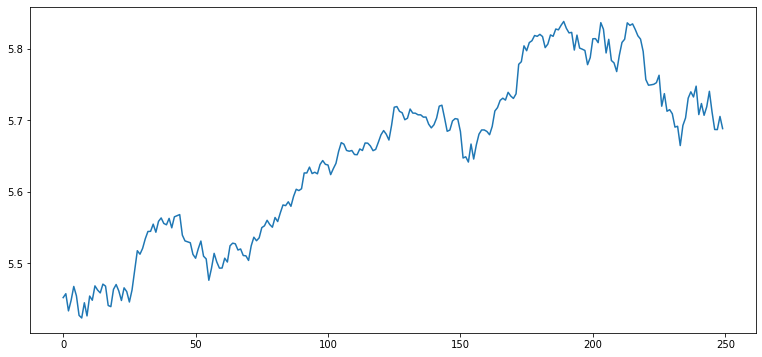

In [725]:
ts_log=np.log(ts2)
plt.plot(ts_log)

In [726]:
augmented_dickey_fuller_test(ts_log) # 0.45 로  0.03정도 떨어진 것을 확인 할수 있다.

Results of Dickey-Fuller Test:
Test Statistic                  -1.655316
p-value                          0.454270
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


#### -2. 이동평균(moving average) 제거하기
- 추세(trend)상쇄를 하기 위해서 moving average를 ts_log에서 빼서 시간추이에 따른 평균이 증가하는 것을 제거해준다.

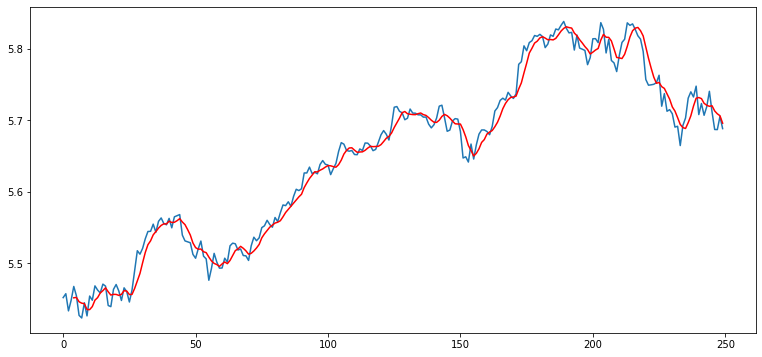

In [727]:
moving_avg = ts_log.rolling(window=5).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [728]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거

# window사이즈가 5개라서 앞의 4개 데이터의 결측치가 발생하기 때문에 결측치 삭제한다.
ts_log_moving_avg.dropna(inplace=True) 
ts_log_moving_avg.head(15)

4     0.015862
5     0.002307
6    -0.018994
7    -0.020664
8     0.001260
9    -0.008857
10    0.018934
11    0.008873
12    0.019966
13    0.010577
14    0.000160
15    0.009101
16    0.002341
17   -0.019202
18   -0.016172
Name: Close, dtype: float64

로그변환을 하고, moving average를 뺀 이후의 변화를 보자

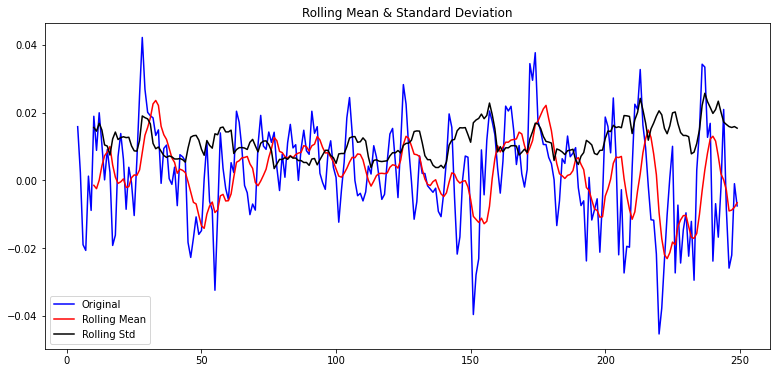

In [729]:
plot_rolling_statistics(ts_log_moving_avg)

In [730]:
augmented_dickey_fuller_test(ts_log_moving_avg) # p-value가 0.61에서 3*10^-6로 매우매우 감소했다.

Results of Dickey-Fuller Test:
Test Statistic                  -5.445454
p-value                          0.000003
#Lags Used                       4.000000
Number of Observations Used    241.000000
Critical Value (1%)             -3.457779
Critical Value (5%)             -2.873609
Critical Value (10%)            -2.573202
dtype: float64


### 주의사항
-  __moving average의 window 사이즈를 어떻게 잡느냐에 따라서__ 시계열데이터에서 moving average를 뺀 이후에 trend를 제거되는지 안되는지가 달라진다. 즉 __시계열 데이터가 안정적이 되는지 안되는지가 달라진다.__

####  차분(differencing)- 계절성(Seasonality) 상쇄하기
- 계절적, 주기적 패턴을 계절성(seasonality)라고 하는데 이런  주기적 변화를 제거한다.


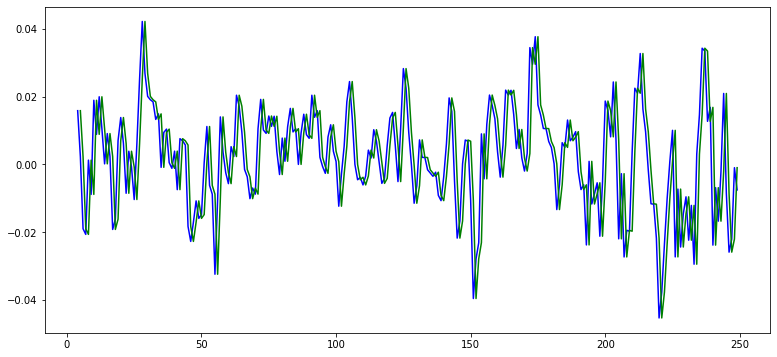

In [731]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift() # 한칸씩 shift

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

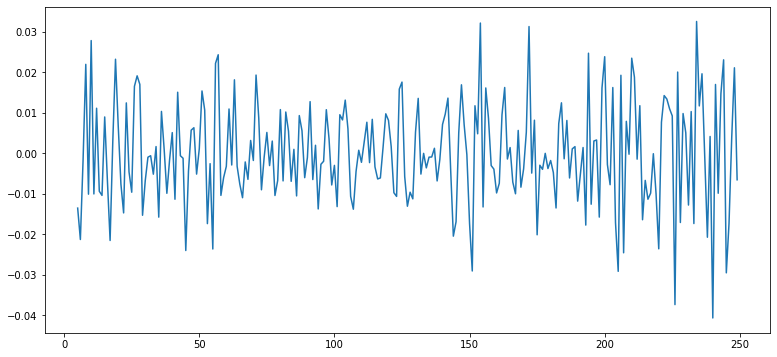

In [732]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

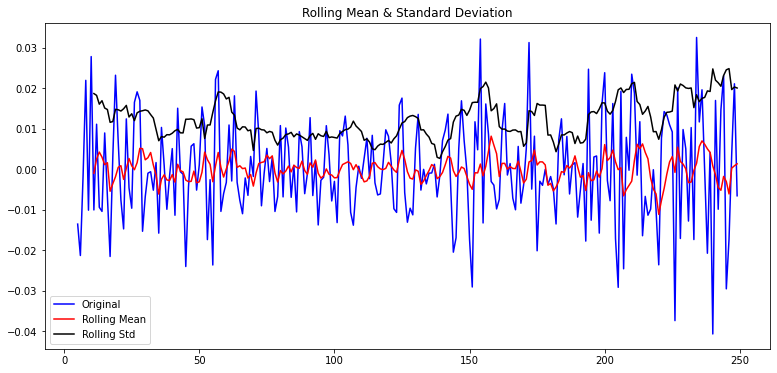

In [733]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [734]:
# log 변환, 이동평균 빼주고  p-value  3.2e-10이다. 
augmented_dickey_fuller_test(ts_log_moving_avg_diff) 

Results of Dickey-Fuller Test:
Test Statistic                -7.145274e+00
p-value                        3.244966e-10
#Lags Used                     1.200000e+01
Number of Observations Used    2.320000e+02
Critical Value (1%)           -3.458855e+00
Critical Value (5%)           -2.874080e+00
Critical Value (10%)          -2.573453e+00
dtype: float64


## 2. 시계열 분해(time series decomposition)
- statsmodels 라이브러리 안의 seasonal_decompose 메서드를 통해서 시계열 안에 존재하는 tred, seasonality를 분리할수 있음.
- 앞에서는 이 과정을 손수 나눠서 빼보는 것이었음. 사실 이거 한번에 하면 됨

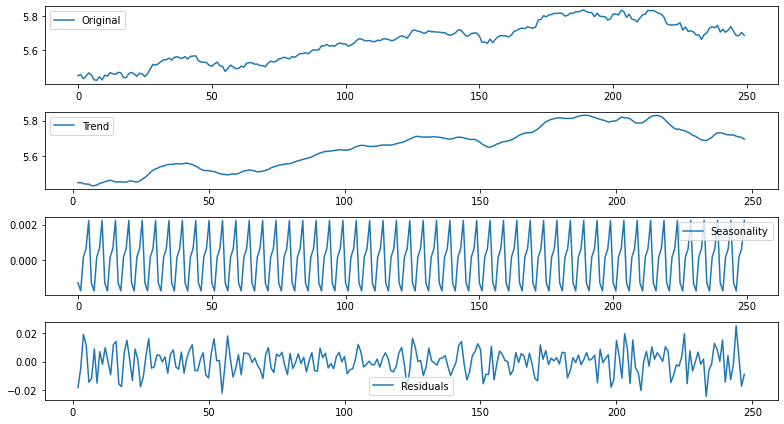

In [735]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='additive', period=5)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

original=trend+seasonal+residual

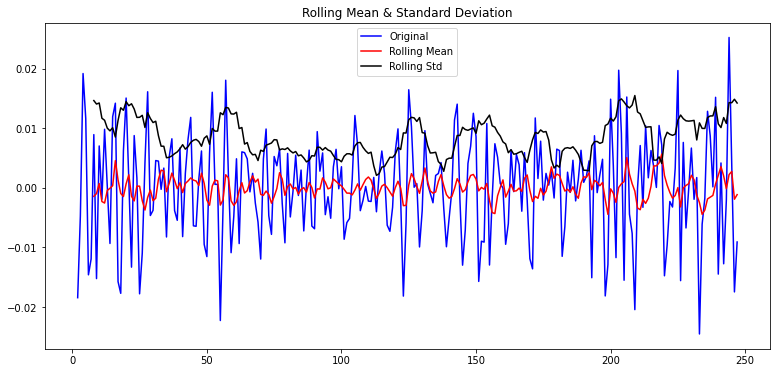

In [736]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [737]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -7.692407e+00
p-value                        1.407850e-11
#Lags Used                     1.200000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


### ARIMA 모델의 모수 p,q,d
- ARIMA를 효과적으로 활용하기 위해 ARIMA 모수(parameter)를 잘 설정해주어야한다.
### ARIMA의 파라미터 p,q,d를 찾는 통계학적인 방법 
> #### ACF(Autocorrelation Function)   
> - lag에 따라 관측치들 사이의 correlation 측정    
>
> #### PACF(Partial Autocorrelation Function)
> - 두 시차의 관측치 사이의 관련성 측정(TODO)

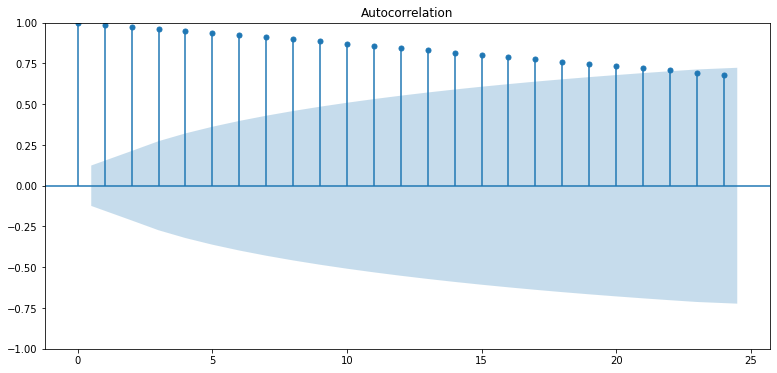

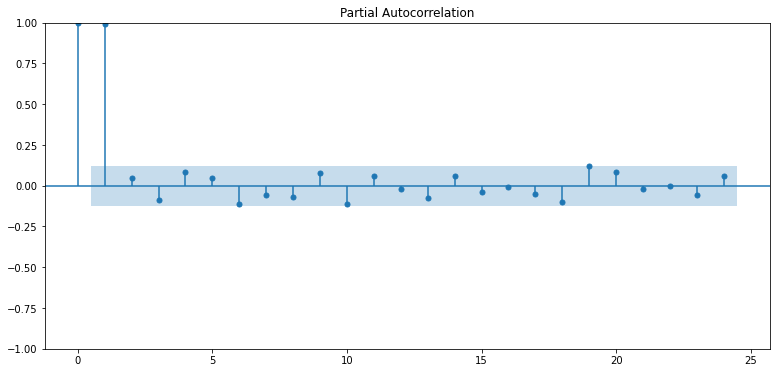

In [738]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

__PACF를 통해 AR 모델의 시차 p를 1이 적합하다고 생각했다. p가 2이상인 구간에서는 PACF는 거의 0에 가까워지기 때문이다. q값은 적합한 값이 없어 보여서 0으로 잡아야겠다.__

Results of Dickey-Fuller Test:
Test Statistic                -1.672390e+01
p-value                        1.401170e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


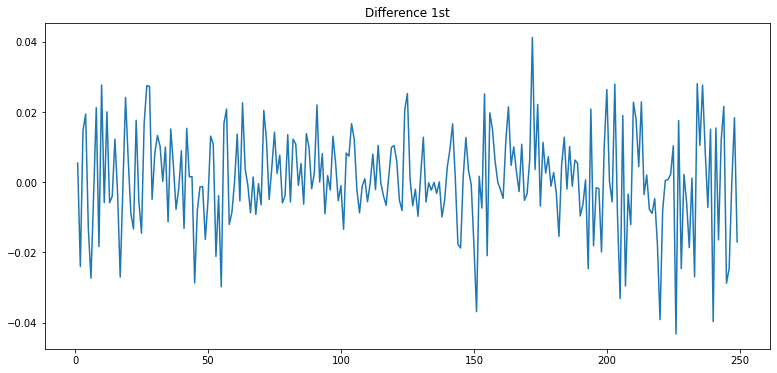

In [739]:
# 1차 차분 구하기 
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1) # P-value: 1.40e-29 많이 안정적이 되었다

Results of Dickey-Fuller Test:
Test Statistic                -9.282095e+00
p-value                        1.243220e-15
#Lags Used                     1.000000e+01
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


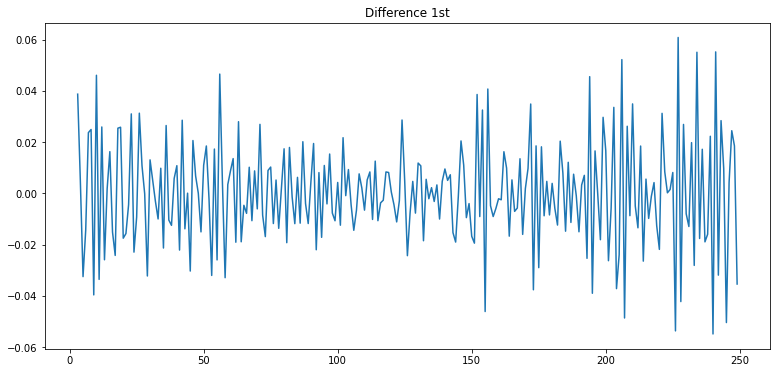

In [740]:
# 2차 차분 구하기 
diff_2 = diff_1.diff(periods=1).iloc[2:]
diff_2.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_2)

- 1차 차분이 적당할 것 같다.

학습데이터 분리

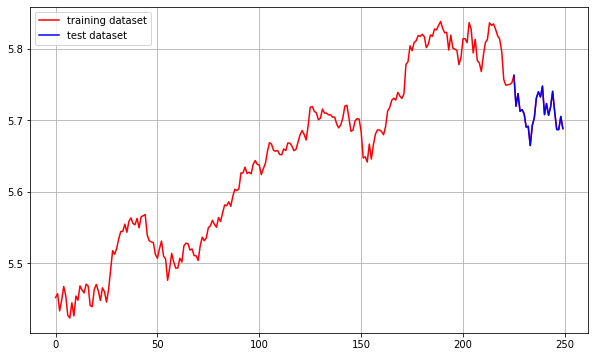

In [741]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  
# train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [742]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

0    5.452197
1    5.457669
Name: Close, dtype: float64
(225,)
(25,)


### ARIMA 모델 훈련과 추론

In [743]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  # 앞에서 본 PACF 그래프와 diff1
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 653.746
Date:                Wed, 16 Feb 2022   AIC                          -1303.493
Time:                        17:14:31   BIC                          -1296.669
Sample:                             0   HQIC                         -1300.738
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0089      0.066      0.134      0.894      -0.121       0.139
sigma2         0.0002    1.5e-05     11.390      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.02   Jarque-

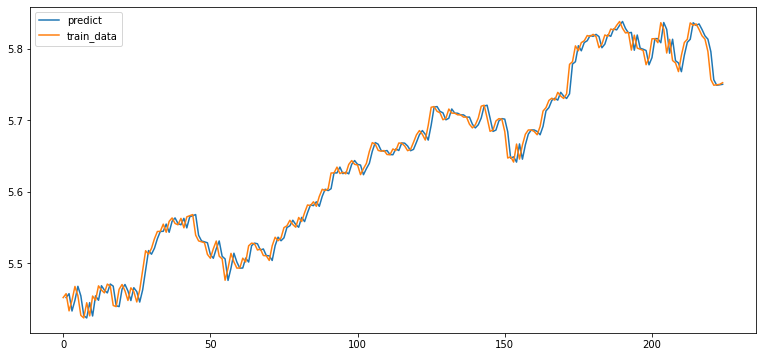

In [744]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

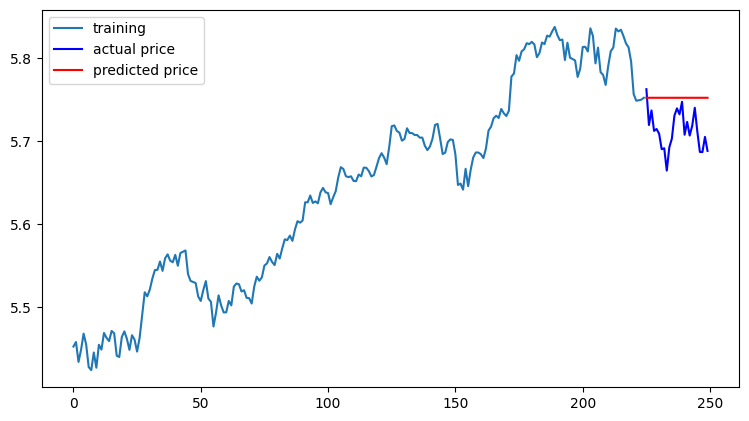

In [745]:
model = ARIMA(train_data, order=(1,1,0))  # 
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [746]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  192.7689515194913
MAE:  12.37067573268427
RMSE:  13.884125882441836
MAPE: 4.13%


### 3. SPDR S&P 500 ETF Trust의 종가 주식을 맞춰보자

In [869]:
ts2 = df2['Close']  
print(type(ts2))
ts1.head()

<class 'pandas.core.series.Series'>


0    133.190002
1    130.839996
2    129.710007
3    129.869995
4    126.000000
Name: Close, dtype: float64

시계열 안정성(stationarity)을 정성적으로 체크한다.

In [870]:
ts2[ts2.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

.[pandas 결측값 보간하기](https://rfriend.tistory.com/264)
결측치가 없지만 보간하는 코드를 돌려보자

Series([], Name: Close, dtype: float64)


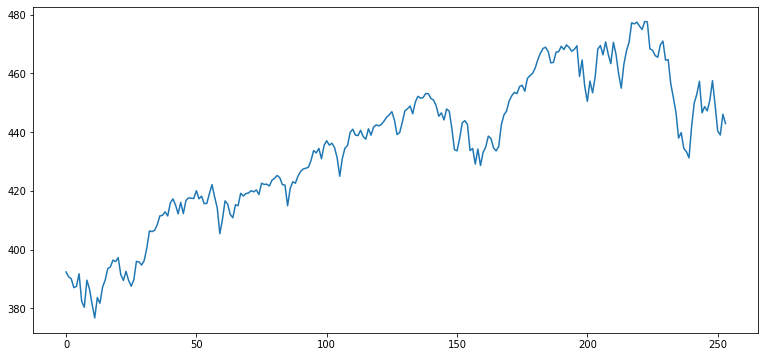

In [871]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts2=ts2.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts2[ts2.isna()])

# 다시 그래프를 확인해봅시다!
plt.plot(ts2)

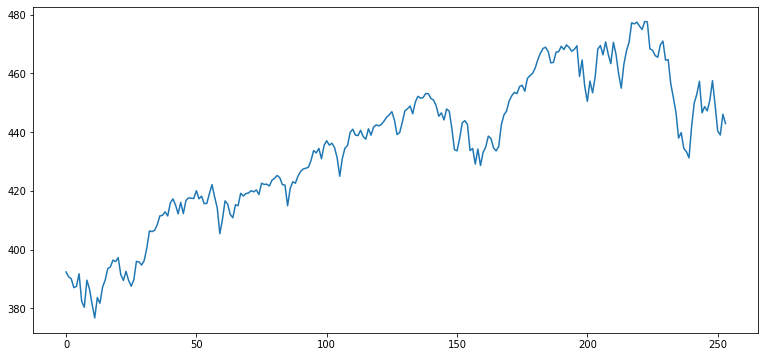

In [866]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts2)

__구간의 평균(rolling mean, 이동평균), 표준편차(rolling std, 이동표준편차)__ 를 추가한 그래프

In [872]:
def plot_rolling_statistics(timeseries, window=7):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


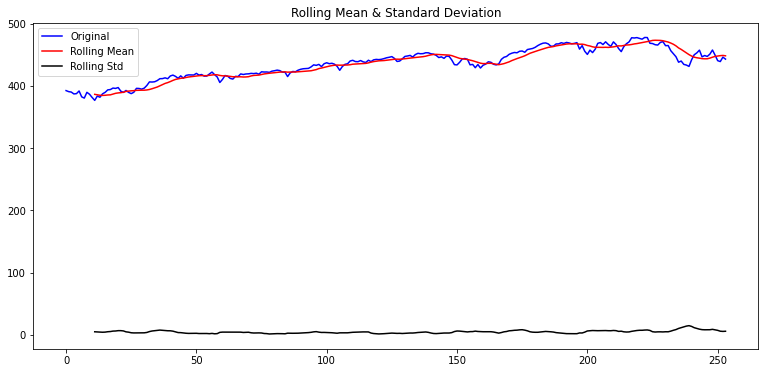

In [877]:
plot_rolling_statistics(ts2, window=12) # 주식시장이 일주일에 5일 

### 시계열 데이터 정량적으로 다뤄보기

#### Augmented Dickey-Fuller Test


In [878]:
from statsmodels.tsa.stattools import adfuller

# ADF 테스트
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


In [879]:
augmented_dickey_fuller_test(ts2)

Results of Dickey-Fuller Test:
Test Statistic                  -1.817465
p-value                          0.371826
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


ADF 테스트 결과 p-value가 0.3으로 작지만, 귀무가설을 기각못합니다.(하지만 시계열 데이터가 non-stationary는 증거는 아니다.)

###  안정적인 시계열로 바꾸기

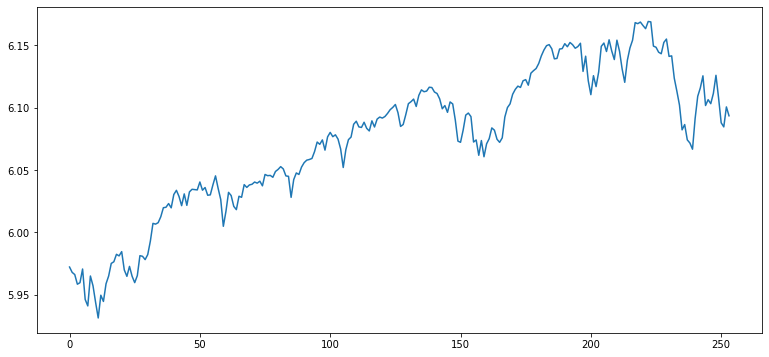

In [880]:
ts_log=np.log(ts2)
plt.plot(ts_log)

In [881]:
augmented_dickey_fuller_test(ts_log)  # 로그변환을 하니까 p-value가 조금 0.01정도 떨어졌다.

Results of Dickey-Fuller Test:
Test Statistic                  -1.834547
p-value                          0.363450
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


####  이동평균(moving average) 제거하기
- 추세(trend)상쇄를 하기 위해서 moving average를 ts_log에서 빼서 시간추이에 따른 평균이 증가하는 것을 제거해준다.

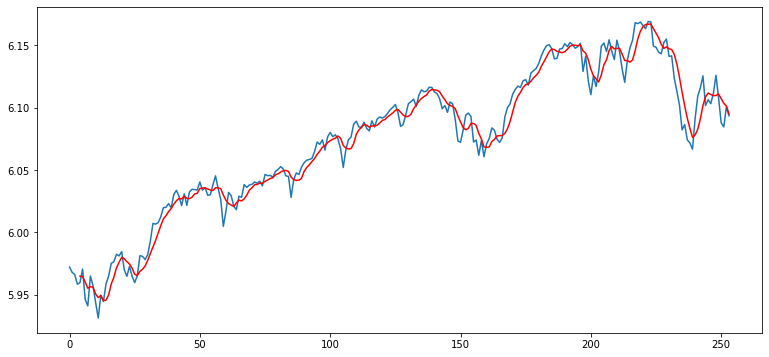

In [883]:
moving_avg = ts_log.rolling(window=5).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [884]:
ts_moving_avg = ts2 - moving_avg # 변화량 제거

# window사이즈가 5개라서 앞의 4개 데이터의 결측치가 발생하기 때문에 결측치 삭제한다.
ts_moving_avg.dropna(inplace=True) 
ts_moving_avg.head(15)

4     381.535062
5     385.805367
6     376.369707
7     374.404726
8     383.623415
9     380.583933
10    375.469291
11    370.752257
12    377.680538
13    375.774611
14    381.224297
15    383.630037
16    387.571308
17    388.095942
18    390.438395
Name: Close, dtype: float64

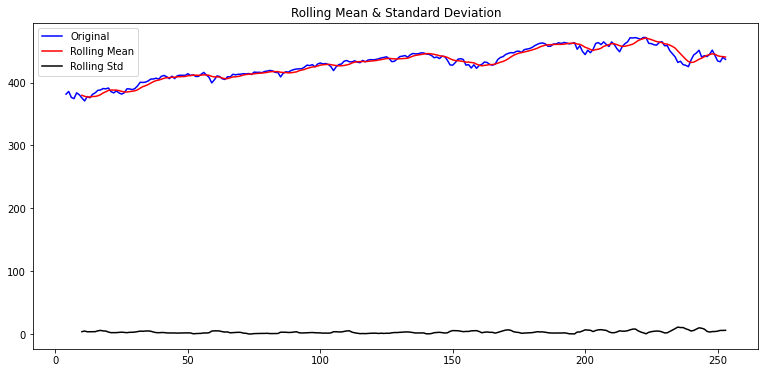

In [890]:
plot_rolling_statistics(ts_moving_avg)

In [891]:
augmented_dickey_fuller_test(ts_moving_avg) # p-value가 0.36에서 0.27로 떨어졌다

Results of Dickey-Fuller Test:
Test Statistic                  -2.035005
p-value                          0.271439
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


#### 1-3. 차분(differencing)- 계절성(Seasonality) 상쇄하기
- 계절적, 주기적 패턴을 계절성(seasonality)라고 하는데 이런  주기적 변화를 제거한다.


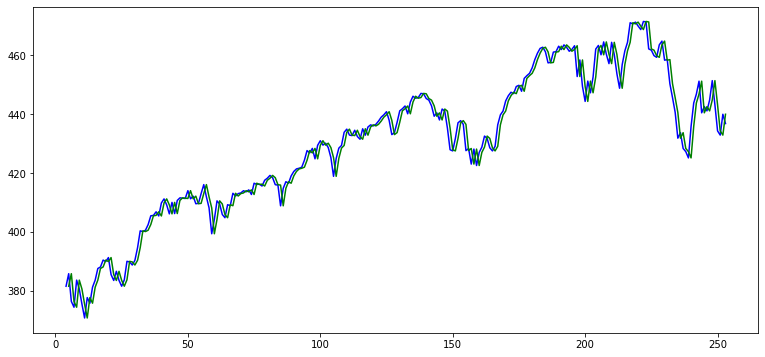

In [892]:
ts_moving_avg_shift = ts_moving_avg.shift() # 한칸씩 shift

plt.plot(ts_moving_avg, color='blue')
plt.plot(ts_moving_avg_shift, color='green')

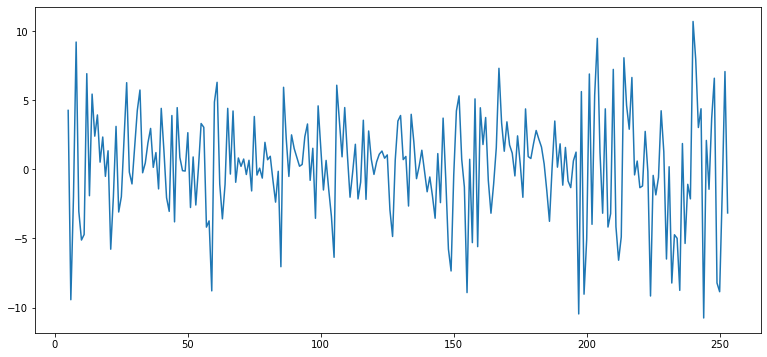

In [893]:
ts_moving_avg_diff = ts_moving_avg - ts_moving_avg_shift
ts_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_moving_avg_diff)

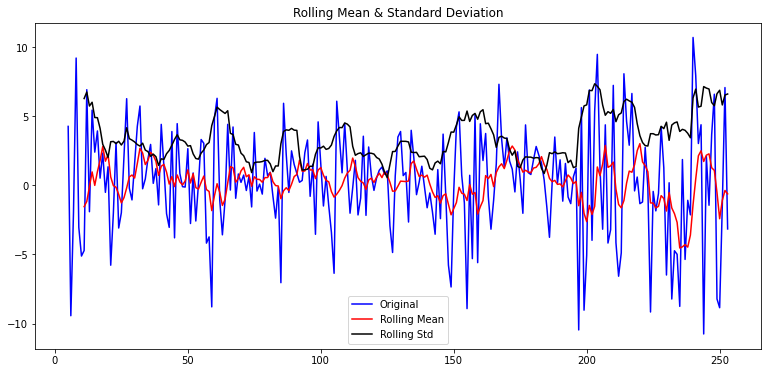

In [894]:
plot_rolling_statistics(ts_moving_avg_diff)

In [896]:
# 이동평균 빼주고  p-value  1.94e-28로 떨어진 것을 확인할수 있다. 
augmented_dickey_fuller_test(ts_moving_avg_diff) 

Results of Dickey-Fuller Test:
Test Statistic                -1.557959e+01
p-value                        1.940214e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


## 2. 시계열 분해(time series decomposition)
- statsmodels 라이브러리 안의 seasonal_decompose 메서드를 통해서 시계열 안에 존재하는 tred, seasonality를 분리할수 있음.
- 앞에서는 이 과정을 손수 나눠서 빼보는 것이었음. 사실 이거 한번에 하면 됨

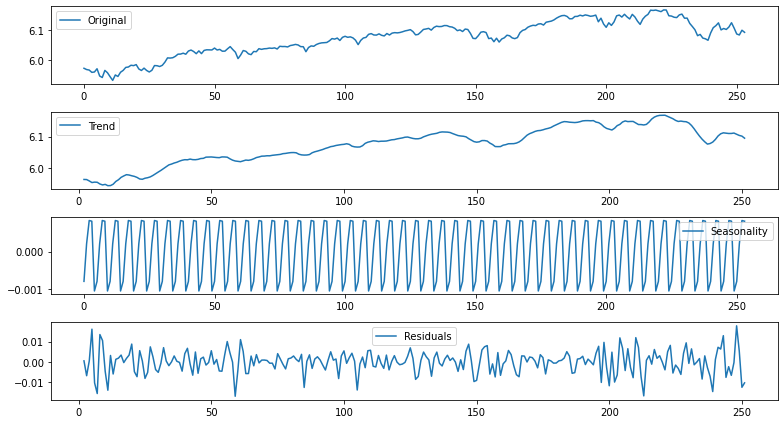

In [897]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='additive', period=5)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

original=trend+seasonal+residual

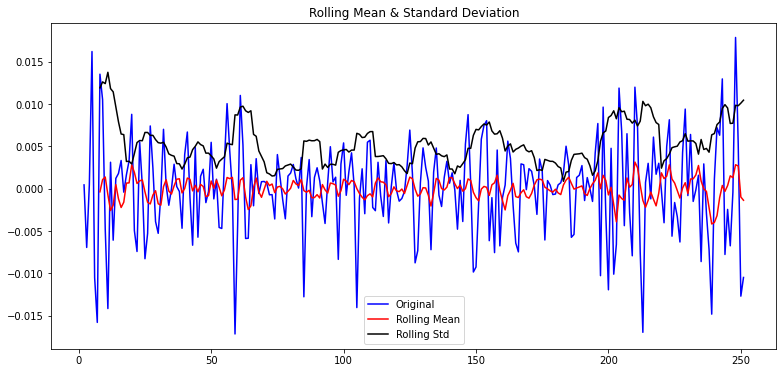

In [898]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [900]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual) # p-value가 1.23e-13이 되었다 즉 안정적인 시계열을 확보한 것 같다.

Results of Dickey-Fuller Test:
Test Statistic                -8.501930e+00
p-value                        1.231655e-13
#Lags Used                     1.200000e+01
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


### ARIMA 모델의 모수 p,q,d를 찾자


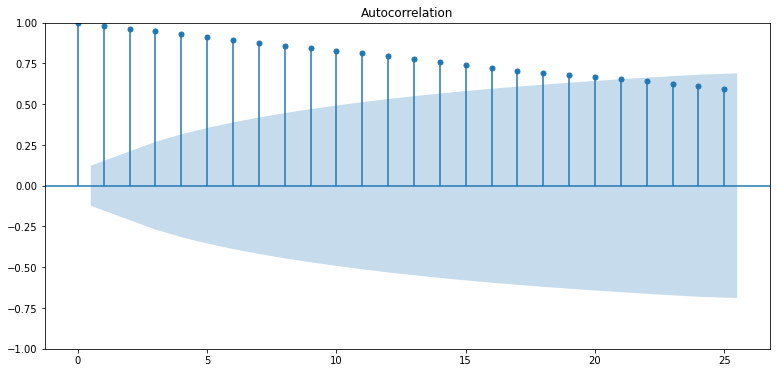

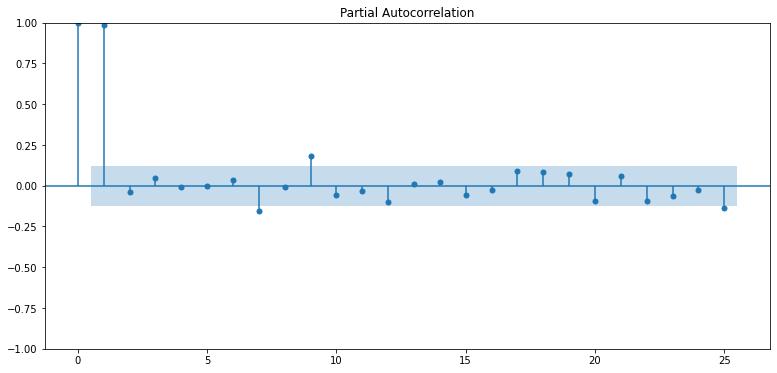

In [901]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

PACF를 통해 AR 모델의 시차 p를 21이 적합하다고 생각했다. p가 1 이후에 거의 0인줄 알았는데 이후에 차수 21에서 한번 더 값이 커지는 것을확인했다. 즉 23이후에  거의 0에 가까워지기 때문에 24를 선택해야겠다고 생각했고, q에 적합한 값은 보이지 않아보인다.

Results of Dickey-Fuller Test:
Test Statistic                -1.575087e+01
p-value                        1.223798e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.520000e+02
Critical Value (1%)           -3.456569e+00
Critical Value (5%)           -2.873079e+00
Critical Value (10%)          -2.572919e+00
dtype: float64


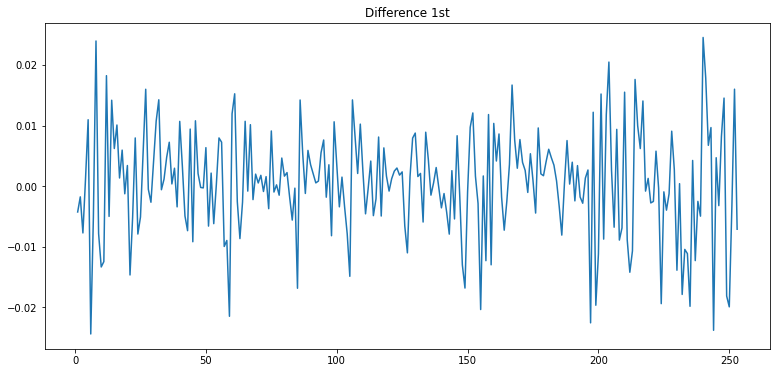

In [902]:
# 1차 차분 구하기 
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.321371e+00
p-value                        3.565105e-13
#Lags Used                     1.300000e+01
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


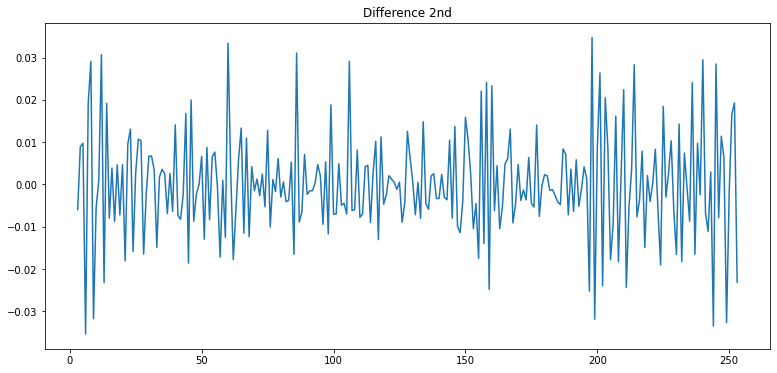

In [903]:
# 2차 차분 구하기 
diff_2 = diff_1.diff(periods=1).iloc[2:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

Results of Dickey-Fuller Test:
Test Statistic                -1.537549e+01
p-value                        3.462865e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


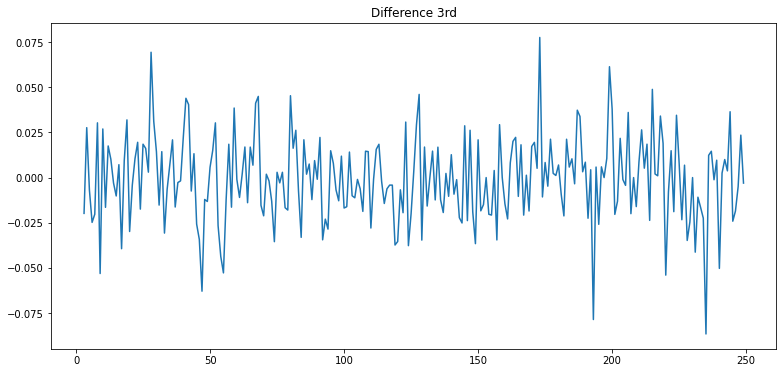

In [800]:
# 3차 차분 구하기 
diff_3 = ts_log.diff(periods=1).iloc[3:]
diff_3.plot(title='Difference 3rd')

augmented_dickey_fuller_test(diff_3) 

- 1차 차분의 ADF-test의 p-value가 가장 낮기 때문에 d를 1로 선택했다.

학습데이터 분리

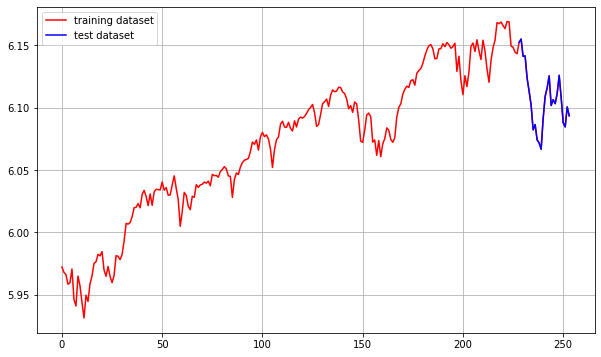

In [904]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  
# train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [905]:
print(ts2[:2])
print(train_data.shape)
print(test_data.shape)

0    392.390015
1    390.720001
Name: Close, dtype: float64
(228,)
(26,)


### ARIMA 모델 훈련과 추론

In [907]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 1, 0)) 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 769.888
Date:                Wed, 16 Feb 2022   AIC                          -1535.776
Time:                        18:01:24   BIC                          -1528.926
Sample:                             0   HQIC                         -1533.012
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0337      0.059     -0.573      0.567      -0.149       0.082
sigma2      6.627e-05   5.67e-06     11.692      0.000    5.52e-05    7.74e-05
Ljung-Box (L1) (Q):                   0.04   Jarque-

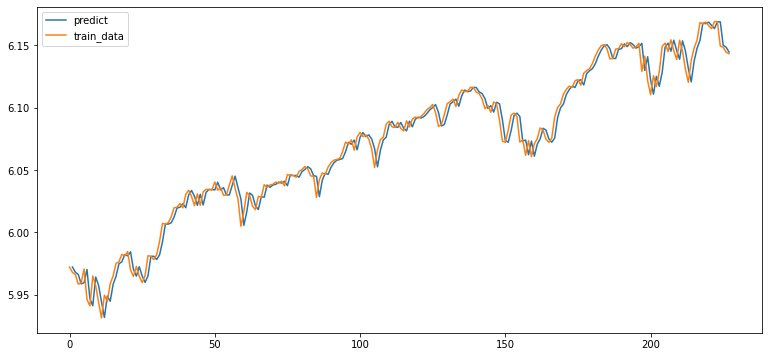

In [908]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

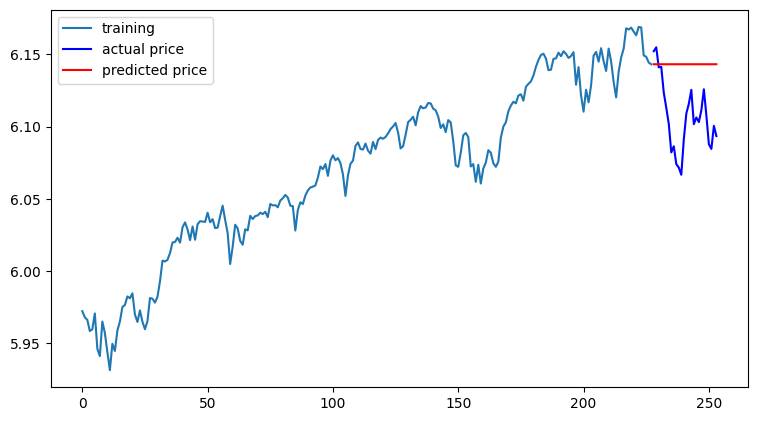

In [910]:
model = ARIMA(train_data, order=(1,1,0))  
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [911]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  385.5852417607203
MAE:  17.31595869981205
RMSE:  19.636324548161255
MAPE: 3.91%


### 예측 결과 MAPE   
- 애플주식의 종가주식 ARIMA 예측 MAPE: 2.61%

- 마이크로소프트의 종가주식 ARIMA 예측 MAPE: 4.13%

- SPDR S&P 500 ETF Trust의 종가 주식 ARIMA 예측: 3.91%

### 회고
- 주식 데이터를 통해서 시계열데이터가 트랜드 + 계절성 + 잔차로 이루어졌다는 것을 알수 있었다.
- ARIMA모형의 p,d,q 파라미터를 찾는 과정이 처음에는 익숙하지 않아서 5조의 강태원님과 2조의 최참님과 ACF와 PACF를 보면서 어떻게 p를 구하는지 배우는 과정에서 이해할 수 있었다. 시계열 데이터를 다루는데 익숙하지 않아서 곤란했었는데 도움을 받아서 무사하게 마무리를 지을 수 있었다. 참 감사했다.
- 미국 주식시장이 주 5일 운행되니까 window수를 5로 잡고 가려고 보니까 미국 주식시장 안에서 휴장일이 있어서 이걸 어떻게 전처리해야할지 고민하고 있는데 최참님께서 "어짜피 주식은 일주일 주기성을 띄는 패턴이 없어요"라고 주식시장에 대한 도메인 지식을 주셨다. 그래서 휴장일을 보간법으로 채우는 등의 일 안하고 그냥 시계열 예측 준비를 하는 것이 타당하게 생각이 되었다. 데이터 분석을 할때는 데이터에 대한 도메인 지식과 데이터의 성질을 잘 알아야지 전처리에도 더 효과적이라는 것을 알수 있게되었다.
- 사실 애플과 마이크로 소프트 예측을 하기 전에 테슬라 데이터를 돌려보았는데 MAPE가 정말 말도 안되게 높게 나왔다. 이에 대해서 최참님께서 "테슬라는 예측이 애당초 예측이 불가능해서 수 많은 사람이 돈을 잃었습니다."라는 말을 듣고 __시계열 데이터가 안정성을 가진 데이터에 한해서 예측이 잘될수 있다는 사실을 다시 한번 상기하게 되었다.__ 아무래도 테슬라의 주식 종가는 자기상관성이 아니라 외부의 이벤트(코로나로 인한 환경이슈, 일론 머스크의 트위터 발언 등등)로 인한 등락이 있다보니 ARIMA를 통한 예측보다는 다른 외부데이터를 통해서 regression 예측을 하는 것이 더 적합하지 않았을까 생각을 해보았다.